In [ ]:
# This Notebook train 10 VAE to generate each a digit, then train a classifieur to solve mnist only with the VAEs. : result 95% accuracy without much finetuning

In [13]:
%matplotlib inline

from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
from fashion import fashion
from torch.utils import data
import matplotlib.pyplot as plt

In [4]:
cuda =  torch.cuda.is_available()
batch_size=128
log_interval=100
epochs=10
seed=1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
class Classif(nn.Module):
    def __init__(self):
        super(Classif, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def classif(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return F.log_softmax(self.fc3(h2))


    def forward(self, x):
        return self.classif(x.view(-1, 784))

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
        self.fc5 = nn.Linear(20, 400) #can eventually share parameters with fc3
        self.fc6 = nn.Linear(400, 10)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def classif(self, z):
        h4 = self.relu(self.fc5(z))
        return F.log_softmax(self.fc6(h4))

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [8]:
def get_list_batch():
    list_digits=[[],[],[],[],[],[],[],[],[],[]]
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size=len(target)
        for i in range(batch_size):
            #list_digits[target[i]].append(batch_idx*batch_size+i)
            list_digits[target[i]].append(data[i])
    return list_digits

def get_batch(list_digits, digit, batch_size):
    liste=list_digits[digit]
    size_list=len(liste)
    plt.imshow(liste[0].numpy()[0])
    batch=np.zeros((batch_size,1,28,28))
    for i in range(batch_size):
        indice=np.random.randint(0, size_list)
        batch[i]=liste[indice].numpy()
    return batch

In [10]:
def train(epoch):
    size_epoch=2000
    model.train()
    train_loss = 0
    train_loss_classif = 0
    digit=(epoch-1)%10
    target = Variable(torch.LongTensor(batch_size).fill_(digit))

    for batch_idx in range(size_epoch):
        data=get_batch(list_digits, digit, batch_size)
        data=torch.FloatTensor(data)
        data = Variable(data)
        if cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        # VAE
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward(retain_variables=True)
        train_loss += loss.data[0]

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), size_epoch,
                100. * batch_idx / size_epoch,
                loss.data[0] / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / size_epoch))
    print('====> Epoch: {} Average loss classif: {:.4f}'.format(
          epoch, train_loss_classif / size_epoch))
    
    
def test(epoch):
    model_classif.eval()
    test_loss = 0
    test_loss_classif = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data = data.cuda()
            target = target.cuda()
        data = Variable(data, volatile=True)
        target = Variable(target, volatile=True)
        #recon_batch, classif, mu, logvar = model_classif(data)
        classif = model_classif(data)
        #test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        
        
        test_loss_classif  += F.nll_loss(classif, target, size_average=False).data[0] # sum up batch loss
        pred = classif.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_classif , correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = data.DataLoader(fashion('fashion_data', train=True, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
test_loader = data.DataLoader(fashion('fashion_data', train=False, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

model = VAE()
if cuda:
    model.cuda()

list_digits=get_list_batch()
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
optimizer = optim.Adam(model.parameters(), lr=1e-3)



Processing...
Done!


/home/timothee/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 784])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/timothee/anaconda2/lib/python2.7/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


Train Epoch: 1 [0/2000 (0%)]	Loss: 549.555115
Train Epoch: 1 [12800/2000 (5%)]	Loss: 304.339233
Train Epoch: 1 [25600/2000 (10%)]	Loss: 294.025513
Train Epoch: 1 [38400/2000 (15%)]	Loss: 297.967682
Train Epoch: 1 [51200/2000 (20%)]	Loss: 285.751984
Train Epoch: 1 [64000/2000 (25%)]	Loss: 280.966003
Train Epoch: 1 [76800/2000 (30%)]	Loss: 276.358063
Train Epoch: 1 [89600/2000 (35%)]	Loss: 287.226501
Train Epoch: 1 [102400/2000 (40%)]	Loss: 269.845459
Train Epoch: 1 [115200/2000 (45%)]	Loss: 280.178436
Train Epoch: 1 [128000/2000 (50%)]	Loss: 265.949371
Train Epoch: 1 [140800/2000 (55%)]	Loss: 274.905487
Train Epoch: 1 [153600/2000 (60%)]	Loss: 277.488739
Train Epoch: 1 [166400/2000 (65%)]	Loss: 279.911804
Train Epoch: 1 [179200/2000 (70%)]	Loss: 272.943756
Train Epoch: 1 [192000/2000 (75%)]	Loss: 273.576447
Train Epoch: 1 [204800/2000 (80%)]	Loss: 262.276276
Train Epoch: 1 [217600/2000 (85%)]	Loss: 274.758026
Train Epoch: 1 [230400/2000 (90%)]	Loss: 269.614655
Train Epoch: 1 [243200/200

Train Epoch: 8 [115200/2000 (45%)]	Loss: 94.422012
Train Epoch: 8 [128000/2000 (50%)]	Loss: 102.028961
Train Epoch: 8 [140800/2000 (55%)]	Loss: 97.656799
Train Epoch: 8 [153600/2000 (60%)]	Loss: 96.079575
Train Epoch: 8 [166400/2000 (65%)]	Loss: 100.559677
Train Epoch: 8 [179200/2000 (70%)]	Loss: 104.318703
Train Epoch: 8 [192000/2000 (75%)]	Loss: 102.274162
Train Epoch: 8 [204800/2000 (80%)]	Loss: 98.736626
Train Epoch: 8 [217600/2000 (85%)]	Loss: 101.169136
Train Epoch: 8 [230400/2000 (90%)]	Loss: 100.222153
Train Epoch: 8 [243200/2000 (95%)]	Loss: 100.332672
====> Epoch: 8 Average loss: 12991.9900
====> Epoch: 8 Average loss classif: 0.0000
Train Epoch: 9 [0/2000 (0%)]	Loss: 212.616653
Train Epoch: 9 [12800/2000 (5%)]	Loss: 177.253082
Train Epoch: 9 [25600/2000 (10%)]	Loss: 162.286621
Train Epoch: 9 [38400/2000 (15%)]	Loss: 159.598923
Train Epoch: 9 [51200/2000 (20%)]	Loss: 156.628235
Train Epoch: 9 [64000/2000 (25%)]	Loss: 162.551453
Train Epoch: 9 [76800/2000 (30%)]	Loss: 170.8310

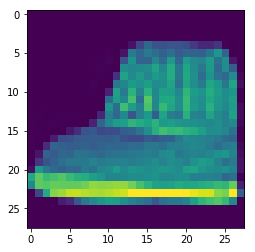

In [15]:
import copy
Generators=[]


for epoch in range(1, epochs + 1):
    train(epoch)
    Generators.append(copy.deepcopy(model.decode))

In [1]:
#Testing of decoder's copy 
dec=Generators[2]


width = 24
height = 24
plt.figure(figsize=(width, height))

hidden_vector=torch.randn((10,20))
hidden_vector=Variable(hidden_vector.cuda())

output=dec(hidden_vector)
img=output.data.cpu().numpy().reshape((10,28,28))

for i in range(10):
    plt.subplot(10,5,i+1)
    plt.imshow(img[i])

NameError: name 'Generators' is not defined

In [28]:
def get_batch_VAE(batch_size, Generators):
    #dirty way of gettingrandom integer for Generators selection
    gene_indice=(torch.randperm(1000)%10)[0:batch_size]
    hidden_vectors=torch.randn((1,20,batch_size))
    batch=torch.FloatTensor(batch_size,28,28)
    target=torch.LongTensor(batch_size)
    for i in range(batch_size):
        target[i]=int(gene_indice[i])
        gene=Generators[target[i]]
        h=Variable(hidden_vectors[:,:,i].cuda())
        batch[i]=gene(h).data.cpu()
    return batch, target

In [29]:
def train_from_VAE(epoch):
    size_epoch=1000
    model_classif.train()
    train_loss = 0
    train_loss_classif = 0

    for batch_idx in range(size_epoch):
        
        data,target=get_batch_VAE(batch_size, Generators)
        data = Variable(data)
        target = Variable(target)
        if cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        
        # Classif
        classif = model_classif(data)
        loss_classif = F.nll_loss(classif, target)
        loss_classif.backward(retain_variables=True)
        train_loss_classif += loss_classif.data[0]

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), size_epoch,
                100. * batch_idx / size_epoch,
                train_loss_classif / len(data)))
    print('====> Epoch: {} Average loss classif: {:.4f}'.format(
          epoch, train_loss_classif / size_epoch))

In [30]:
model_classif=Classif()
model_classif=model_classif.cuda()
optimizer = optim.Adam(model_classif.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train_from_VAE(epoch)
    test(epoch)

Train Epoch: 1 [0/1000 (0%)]	Loss: 0.018058
Train Epoch: 1 [12800/1000 (10%)]	Loss: 1.032364
Train Epoch: 1 [25600/1000 (20%)]	Loss: 1.767669
Train Epoch: 1 [38400/1000 (30%)]	Loss: 2.429802
Train Epoch: 1 [51200/1000 (40%)]	Loss: 3.032853
Train Epoch: 1 [64000/1000 (50%)]	Loss: 3.595910
Train Epoch: 1 [76800/1000 (60%)]	Loss: 4.133637
Train Epoch: 1 [89600/1000 (70%)]	Loss: 4.641914
Train Epoch: 1 [102400/1000 (80%)]	Loss: 5.135811
Train Epoch: 1 [115200/1000 (90%)]	Loss: 5.617073
====> Epoch: 1 Average loss classif: 0.7757
====> Test set loss: 0.0000

Test set: Average loss: 9050.4375, Accuracy: 7875/10000 (79%)

Train Epoch: 2 [0/1000 (0%)]	Loss: 0.004784
Train Epoch: 2 [12800/1000 (10%)]	Loss: 0.452214
Train Epoch: 2 [25600/1000 (20%)]	Loss: 0.881167
Train Epoch: 2 [38400/1000 (30%)]	Loss: 1.303420
Train Epoch: 2 [51200/1000 (40%)]	Loss: 1.714385
Train Epoch: 2 [64000/1000 (50%)]	Loss: 2.127639
Train Epoch: 2 [76800/1000 (60%)]	Loss: 2.533361
Train Epoch: 2 [89600/1000 (70%)]	Loss:

# Print sample from the different VAE trained to train the classifieur

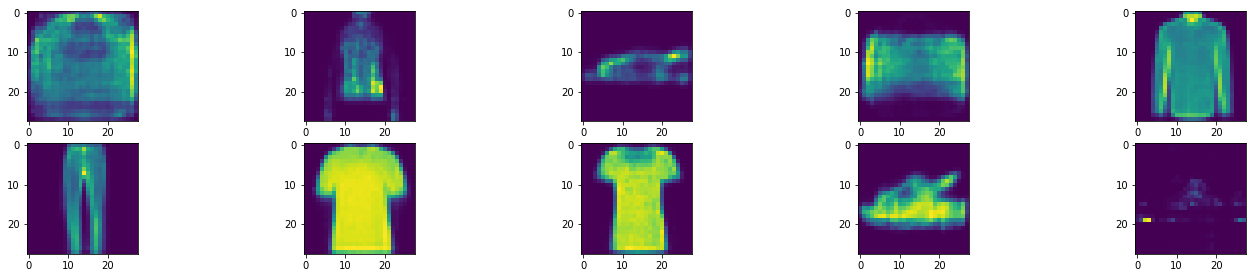

In [31]:
width = 24
height = 24
plt.figure(figsize=(width, height))


batch,target=get_batch_VAE(10, Generators)
img=batch.numpy().reshape((10,28,28))
for i in range(10):
    plt.subplot(10,5,i+1)
    plt.imshow(img[i])

# random sample after training with memories. Only half the sample are memories at the end of training (92%)

[[2 0 0 0 6]
 [0 2 0 2 0]]
[[ 0.116  0.075  0.134  0.086  0.102  0.099  0.094  0.094  0.114  0.085]
 [ 0.165  0.097  0.103  0.086  0.091  0.062  0.087  0.075  0.096  0.138]
 [ 0.140  0.095  0.114  0.086  0.094  0.100  0.123  0.080  0.078  0.090]
 [ 0.158  0.114  0.118  0.085  0.087  0.090  0.089  0.094  0.084  0.081]
 [ 0.121  0.105  0.090  0.072  0.077  0.091  0.149  0.088  0.100  0.107]
 [ 0.141  0.114  0.112  0.082  0.060  0.084  0.093  0.082  0.107  0.124]
 [ 0.139  0.089  0.160  0.075  0.081  0.083  0.082  0.112  0.095  0.085]
 [ 0.118  0.080  0.116  0.105  0.107  0.083  0.106  0.096  0.111  0.078]
 [ 0.107  0.096  0.126  0.101  0.075  0.097  0.103  0.099  0.102  0.095]
 [ 0.143  0.089  0.095  0.073  0.101  0.083  0.115  0.074  0.128  0.099]]


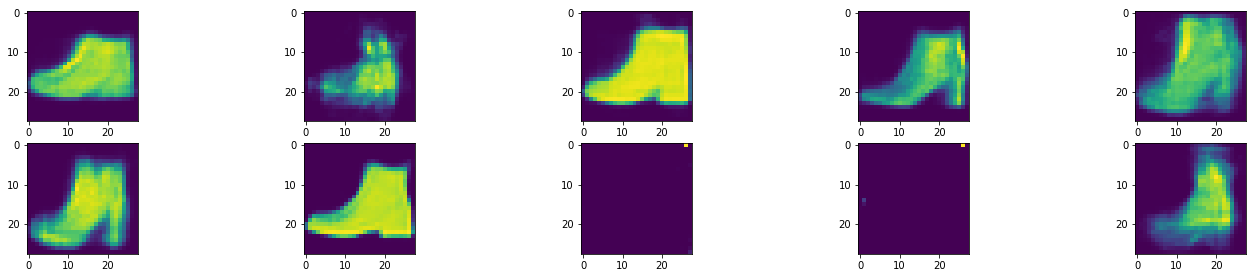

In [32]:
width = 24
height = 24
plt.figure(figsize=(width, height))

hidden_vector=torch.randn((10,20))
#hidden_vector=torch.ones((10,20))*0.0
#hidden_vector[0]=torch.from_numpy(np.array(range(20))*0.05)

hidden_vector=Variable(hidden_vector.cuda())
classif=model.classif(hidden_vector)

output=model.decode(hidden_vector)
img=output.data.cpu().numpy().reshape((10,28,28))

for i in range(10):
    plt.subplot(10,5,i+1)
    plt.imshow(img[i])
print(classif.data.max(1)[1].cpu().numpy().transpose().reshape(2,5))

#print(np.exp(classif.data.cpu().numpy()).transpose())


np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(np.exp(classif.data.cpu().numpy()))